# Deep Deterministic Policy Gradient (DDPG)

**Author:** [amifunny](https://github.com/amifunny)<br>
**Date created:** 2020/06/04<br>
**Last modified:** 2020/09/21<br>
**Description:** Implementing DDPG algorithm on the Inverted Pendulum Problem.

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG,
which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, hence keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.

Now, let's see how is it implemented.

In [8]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
random.seed(0)

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [10]:
problem = "Pendulum-v1"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


To implement better exploration by the Actor network, we use noisy perturbations,
specifically
an **Ornstein-Uhlenbeck process** for generating noise, as described in the paper.
It samples noise from a correlated normal distribution.

In [11]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


The `Buffer` class implements Experience Replay.

---
![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)
---


**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [12]:

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [13]:

def get_actor(reg = "bn"):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    if reg=="bn":
        inputs = layers.Input(shape=(num_states,))
        out = layers.Dense(256, activation="relu")(inputs)
        out = layers.BatchNormalization()(out)
        out = layers.Dense(256, activation="relu")(out)
        out = layers.BatchNormalization()(out)
        outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

        # Our upper bound is 2.0 for Pendulum.
        outputs = outputs * upper_bound
    if reg=="dropout":
        inputs = layers.Input(shape=(num_states,))
        out = layers.Dense(256, activation="relu")(inputs)
        out = layers.Dropout(0.1)(out)
        out = layers.Dense(256, activation="relu")(out)
        out = layers.Dropout(0.1)(out)
        outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

        # Our upper bound is 2.0 for Pendulum.
        outputs = outputs * upper_bound

    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic(reg = "bn"):
    # State as input
    state_input = layers.Input(shape=(num_states))
    if reg=="bn":
        
        state_out = layers.Dense(16, activation="relu")(state_input)
        state_out = layers.BatchNormalization()(state_out)
        state_out = layers.Dense(32, activation="relu")(state_out)

        # Action as input
        action_input = layers.Input(shape=(num_actions))
        action_out = layers.Dense(32, activation="relu")(action_input)

        # Both are passed through seperate layer before concatenating
        concat = layers.Concatenate()([state_out, action_out])

        out = layers.Dense(256, activation="relu")(concat)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(1)(out)

    if reg=="dropout":
        
        state_out = layers.Dense(16, activation="relu")(state_input)
        state_out = layers.Dropout(0.1)(state_out)
        state_out = layers.Dense(32, activation="relu")(state_out)

        # Action as input
        action_input = layers.Input(shape=(num_actions))
        action_out = layers.Dense(32, activation="relu")(action_input)

        # Both are passed through seperate layer before concatenating
        concat = layers.Concatenate()([state_out, action_out])

        out = layers.Dense(256, activation="relu")(concat)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [14]:

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


## Training hyperparameters

1e3_sgd_bn
Episode * 0 * Avg Reward is ==> -1281.7065689988494
Episode * 20 * Avg Reward is ==> -1515.8873523172049
Episode * 40 * Avg Reward is ==> -1337.2687571796146
Episode * 60 * Avg Reward is ==> -1043.7840822181201
Episode * 80 * Avg Reward is ==> -1074.8121940701542
Episode * 100 * Avg Reward is ==> -775.5022510088329


C:\Users\surajp\miniconda3\envs\nlpu\lib\site-packages\gym\envs\classic_control\pendulum.py:229: RuntimeWarning: invalid value encountered in double_scalars
  return ((x + np.pi) % (2 * np.pi)) - np.pi


Episode * 120 * Avg Reward is ==> nan
Episode * 140 * Avg Reward is ==> nan
Episode * 160 * Avg Reward is ==> nan
Episode * 180 * Avg Reward is ==> nan


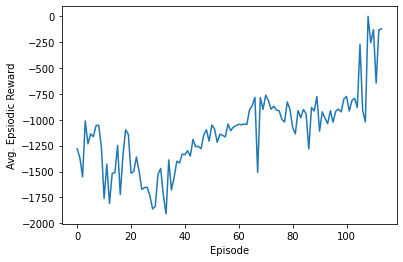

1e3_sgd_dropout
Episode * 0 * Avg Reward is ==> -894.1523138138833
Episode * 20 * Avg Reward is ==> -1626.4872885867694
Episode * 40 * Avg Reward is ==> -1789.7052390877234
Episode * 60 * Avg Reward is ==> -1839.2831704724567
Episode * 80 * Avg Reward is ==> -1184.5987594638125
Episode * 100 * Avg Reward is ==> -1421.007047549269
Episode * 120 * Avg Reward is ==> -1157.731790305962
Episode * 140 * Avg Reward is ==> -1516.41839223823
Episode * 160 * Avg Reward is ==> -851.9900944566373
Episode * 180 * Avg Reward is ==> nan


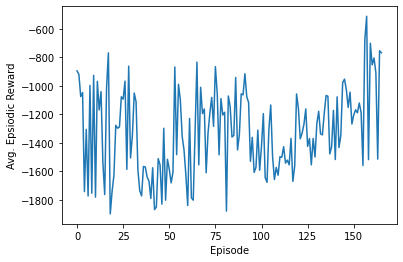

1e3_adam_bn
Episode * 0 * Avg Reward is ==> -979.552277498383
Episode * 20 * Avg Reward is ==> -1431.9469849766447
Episode * 40 * Avg Reward is ==> -809.9326341267978
Episode * 60 * Avg Reward is ==> -128.47552558347797
Episode * 80 * Avg Reward is ==> -381.895525813076
Episode * 100 * Avg Reward is ==> -246.19051864069993
Episode * 120 * Avg Reward is ==> -133.96873861404922
Episode * 140 * Avg Reward is ==> -128.38193057098746
Episode * 160 * Avg Reward is ==> -251.9837000897287
Episode * 180 * Avg Reward is ==> -137.14119857662078


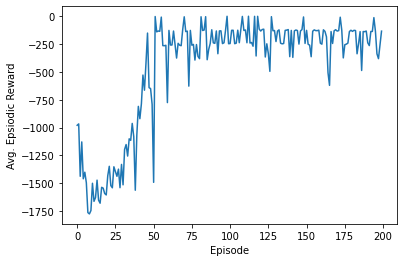

1e3_adam_dropout
Episode * 0 * Avg Reward is ==> -1419.7400808679874
Episode * 20 * Avg Reward is ==> -1524.3239744589514
Episode * 40 * Avg Reward is ==> -916.4948045107997
Episode * 60 * Avg Reward is ==> -1086.8541229402963
Episode * 80 * Avg Reward is ==> -122.40098560352338
Episode * 100 * Avg Reward is ==> -115.09215919471802
Episode * 120 * Avg Reward is ==> -240.7466456534843
Episode * 140 * Avg Reward is ==> -5.740136257174891
Episode * 160 * Avg Reward is ==> -230.53438485062227
Episode * 180 * Avg Reward is ==> -242.02241342293078


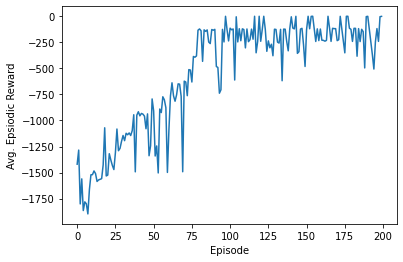

1e4_sgd_bn
Episode * 0 * Avg Reward is ==> -1339.536360675345
Episode * 20 * Avg Reward is ==> -1695.5446888941267
Episode * 40 * Avg Reward is ==> -1136.5260817067833
Episode * 60 * Avg Reward is ==> -1247.6990589368252
Episode * 80 * Avg Reward is ==> -1334.5112095079958
Episode * 100 * Avg Reward is ==> -1062.2637730475676
Episode * 120 * Avg Reward is ==> -1189.5272734522675
Episode * 140 * Avg Reward is ==> -858.5892250916093
Episode * 160 * Avg Reward is ==> -763.4669272973508
Episode * 180 * Avg Reward is ==> -520.9213168025293


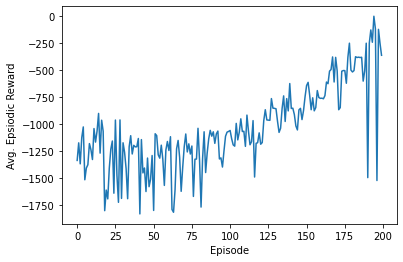

1e4_sgd_dropout
Episode * 0 * Avg Reward is ==> -966.7426759754322
Episode * 20 * Avg Reward is ==> -1217.4294797449263
Episode * 40 * Avg Reward is ==> -1750.9555160131467
Episode * 60 * Avg Reward is ==> -1268.7796785307214
Episode * 80 * Avg Reward is ==> -1821.499467212281
Episode * 100 * Avg Reward is ==> -1253.2482683774351
Episode * 120 * Avg Reward is ==> -1169.3415405880694
Episode * 140 * Avg Reward is ==> -1205.9738156049318
Episode * 160 * Avg Reward is ==> -1191.462643604931
Episode * 180 * Avg Reward is ==> -1458.9037681728912


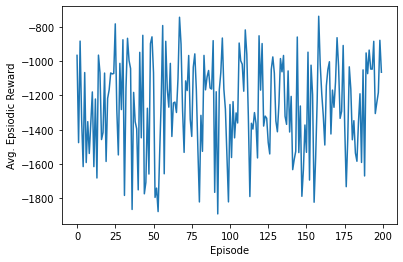

1e4_adam_bn
Episode * 0 * Avg Reward is ==> -1768.676901237204
Episode * 20 * Avg Reward is ==> -1593.4650899192495
Episode * 40 * Avg Reward is ==> -631.8231664644585
Episode * 60 * Avg Reward is ==> -268.59313285428976
Episode * 80 * Avg Reward is ==> -399.70994223577844
Episode * 100 * Avg Reward is ==> -255.82313954766505
Episode * 120 * Avg Reward is ==> -128.17231538065707
Episode * 140 * Avg Reward is ==> -131.27867513278662
Episode * 160 * Avg Reward is ==> -2.213135075548248
Episode * 180 * Avg Reward is ==> -126.69485403318336


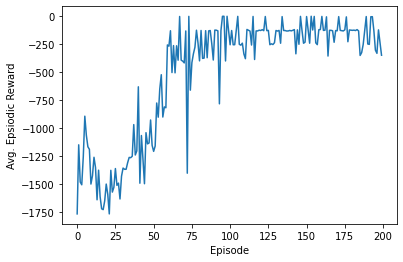

1e4_adam_dropout
Episode * 0 * Avg Reward is ==> -1290.262503306086
Episode * 20 * Avg Reward is ==> -1201.9301780642456
Episode * 40 * Avg Reward is ==> -1466.5665085145054
Episode * 60 * Avg Reward is ==> -1190.9420736437
Episode * 80 * Avg Reward is ==> -757.955307925579
Episode * 100 * Avg Reward is ==> -1212.3381338956221
Episode * 120 * Avg Reward is ==> -1053.1971798825584
Episode * 140 * Avg Reward is ==> -507.26705453474756
Episode * 160 * Avg Reward is ==> -710.6757768671469
Episode * 180 * Avg Reward is ==> -504.8004777149072


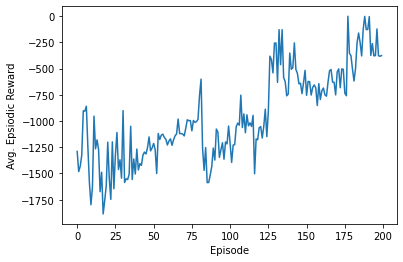

<Figure size 432x288 with 0 Axes>

In [16]:
total_episodes = 200
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.001

for lr_name, lr_ in zip(["1e3", "1e4"], [1e-3, 1e-4]):
    for opt_name in (["sgd", "adam"]):
        for reg_name in (["bn", "dropout"]):

            print(f"{lr_name}_{opt_name}_{reg_name}")

            actor_model = get_actor(reg=reg_name)
            critic_model = get_critic(reg=reg_name)

            target_actor = get_actor(reg=reg_name)
            target_critic = get_critic(reg=reg_name)

            # Making the weights equal initially
            target_actor.set_weights(actor_model.get_weights())
            target_critic.set_weights(critic_model.get_weights())

            actor_model.save_weights(f"models/actor_{lr_name}_{opt_name}_{reg_name}_{0}.h5")
            critic_model.save_weights(f"models/critic_{lr_name}_{opt_name}_{reg_name}_{0}.h5")

            target_actor.save_weights(f"models/actor_target_{lr_name}_{opt_name}_{reg_name}_{0}.h5")
            target_critic.save_weights(f"models/critic_target_{lr_name}_{opt_name}_{reg_name}_{0}.h5")    

            #we set actor learnign reate to be lower than critic as shown in example
            if opt_name=="adam":
                critic_optimizer = tf.keras.optimizers.Adam(2*lr_)
                actor_optimizer = tf.keras.optimizers.Adam(lr_) 

            elif opt_name =="sgd":
                critic_optimizer = tf.keras.optimizers.SGD(2*lr_)
                actor_optimizer = tf.keras.optimizers.SGD(lr_) 

            
            std_dev = 0.2

            ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

            buffer = Buffer(50000, 64)

            # To store reward history of each episode
            ep_reward_list = []
            # To store average reward history of last few episodes
            avg_reward_list = []

            # Takes about 4 min to train
            for ep in range(total_episodes):

                prev_state = env.reset()
                episodic_reward = 0
                
                while True:

                    # Uncomment this to see the Actor in action
                    # But not in a python notebook.

                    #if ep%20==0:
                    #    env.render()

                    tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                    action = policy(tf_prev_state, ou_noise)
                    # Recieve state and reward from environment.
                    state, reward, done, info = env.step(action)

                    buffer.record((prev_state, action, reward, state))
                    episodic_reward += reward

                    buffer.learn()
                    update_target(target_actor.variables, actor_model.variables, tau)
                    update_target(target_critic.variables, critic_model.variables, tau)

                    # End this episode when `done` is True
                    if done:
                        break

                    prev_state = state

                ep_reward_list.append(episodic_reward)

                # Mean of last 40 episodes
                avg_reward = np.mean(ep_reward_list[-1])
                if ep%20==0:
                    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
                avg_reward_list.append(avg_reward)

            # Plotting graph
            # Episodes versus Avg. Rewards
            plt.plot(avg_reward_list)
            plt.xlabel("Episode")
            plt.ylabel("Avg. Epsiodic Reward")
            plt.show()
            plt.savefig(f'{lr_name}_{opt_name}_{reg_name}.png')
            pd.Series(avg_reward_list).to_csv(f"models/{lr_name}_{opt_name}_{reg_name}.csv")

            # Save the weights
            actor_model.save_weights(f"models/actor_{lr_name}_{opt_name}_{reg_name}_{ep}.h5")
            critic_model.save_weights(f"models/critic_{lr_name}_{opt_name}_{reg_name}_{ep}.h5")

            target_actor.save_weights(f"models/actor_target_{lr_name}_{opt_name}_{reg_name}_{ep}.h5")
            target_critic.save_weights(f"models/critic_target_{lr_name}_{opt_name}_{reg_name}_{ep}.h5")    

In [49]:
rewards_df = {}
for lr_name, lr_ in zip(["1e3", "1e4"], [1e-3, 1e-4]):
    for opt_name in ["sgd", "adam"]:
        for reg_name in ["bn", "dropout"]:

            model_config = f"{lr_name}_{opt_name}_{reg_name}"
            print(model_config)

            df = pd.read_csv("models/"+model_config+".csv", index_col=0)
            rewards_df[model_config] = df.iloc[:, 0].values

rewards_df = pd.DataFrame.from_dict(rewards_df)

1e3_sgd_bn
1e3_sgd_dropout
1e3_adam_bn
1e3_adam_dropout
1e4_sgd_bn
1e4_sgd_dropout
1e4_adam_bn
1e4_adam_dropout


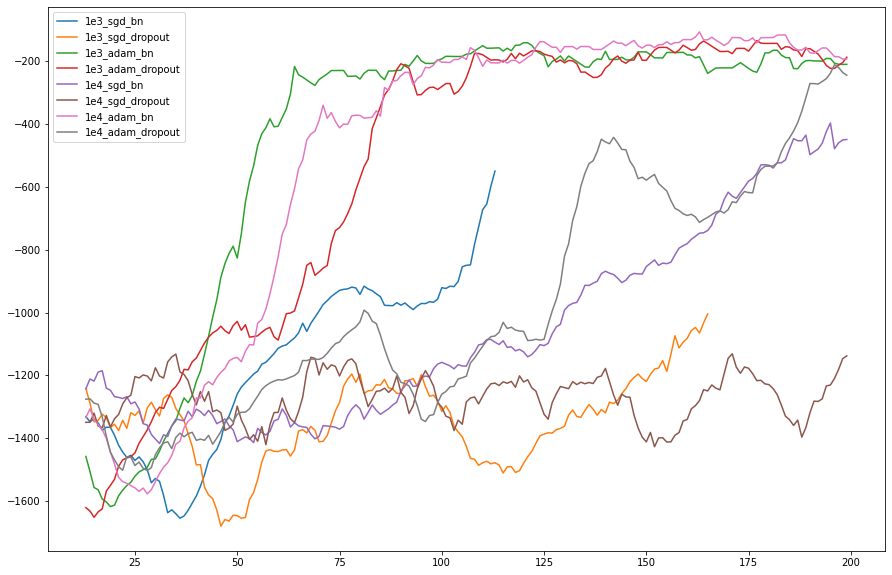

In [64]:
rewards_df.rolling(14).mean().plot(figsize=(15, 10))
plt.show()